In [1]:
from datasets import Dataset, load_dataset, DatasetDict, ClassLabel
import numpy as np
import torch
import pandas as pd

#Seeding for deterministic results i.e. showing same output 
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE', 
                             'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'])]


In [3]:
function_mapping = {'OTHER': ['admiration', 'approval', 'gratitude', 'amusement', 'curiosity', 'embarrassment', 'love', 'optimism', 'joy', 
                              'realization', 'confusion', 'caring', 'excitement', 'surprise', 'desire', 'pride', 'relief', 'neutral'], 
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust', 'annoyance'], 
           'NOT_CORRECT': ['disapproval'], 
           'PESSIMISTIC':['grief', 'remorse', 'sadness'], 
           'WORRIED':['fear', 'nervousness'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': ['disappointment'], 
           'BORED': [''], 
           'NOT_APPROVE':['disapproval'], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': ['disapproval'], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

go_emotions = load_dataset("go_emotions").remove_columns("id")
def adjust_labels(batch):
    batch['emotions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["labels"]):
        batch["emotions"][i] = [mapping[label] for label in batch["labels"][i]]
    return batch

go_emotions = go_emotions.map(adjust_labels, batched=True)
def map_labels(batch):
    batch['functions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["emotions"]):
        batch["functions"][i] = [key for key,value in function_mapping.items() if any(emotion in batch["emotions"][i] for emotion in value)]
    return batch
go_emotions = go_emotions.map(map_labels, batched=True).remove_columns("labels")

for split in go_emotions.keys():
    new_examples = []
    for example in go_emotions[split]:
        for label in example['functions']:
            new_example = {'text': example['text'], 'emotions': example['emotions'],'function': label}
            new_examples.append(new_example)
    go_emotions[split] = Dataset.from_pandas(pd.DataFrame(data=new_examples))

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
100%|██████████| 3/3 [00:00<00:00, 761.03it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1c4d70c4ecc5a4bd.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-8f90b5d8ac946ce8.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-f0dc721270e34384.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified

In [4]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)).shuffle(seed=42),
    "valid": go_emotions['validation'],
    "test": go_emotions['test']
}
    )

In [5]:
dataset['test'][37]

{'text': "What's that like? Like what's the thought process? I dunno. I know what's a weird question..i just can't imagine",
 'emotions': ['neutral'],
 'function': 'OTHER'}

In [6]:
dataset = dataset.class_encode_column("function")
labels = dataset['train'].features['function']
dataset = dataset.rename_column("function", "label")
print(labels.names)

Casting to class labels: 100%|██████████| 7/7 [00:00<00:00, 456.25ba/s]

['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE', 'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED']


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'cardiffnlp/twitter-xlm-roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(transformer_model, num_labels = len(labels.names))).to(device)
tokenizer=AutoTokenizer.from_pretrained(transformer_model)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

ds_enc = dataset.map(tokenize, batched=True, batch_size=None)
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")
ds_enc

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.out

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 629
    })
    valid: Dataset({
        features: ['text', 'emotions', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6385
    })
    test: Dataset({
        features: ['text', 'emotions', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6275
    })
})

In [8]:
from sklearn.metrics import precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [9]:
from transformers import TrainingArguments, Trainer

batch_size = 16
model_name = "functions_basic_finetuning_single_label"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,        
        report_to='none',
    )

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_enc["train"],
                  eval_dataset=ds_enc["valid"],                    
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/njfernandez/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 629
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 278050569
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` metho

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.673431,0.077247,0.111111,0.091135
2,No log,1.617068,0.077242,0.111086,0.091123
3,No log,1.565487,0.159607,0.126024,0.112959
4,No log,1.584714,0.165030,0.162904,0.127012
5,No log,1.589157,0.169540,0.169013,0.128995


The following columns in the evaluation set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotions, text. If emotions, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6385
  Batch size = 32
Saving model checkpoint to functions_basic_finetuning_single_label/checkpoint-20
Configuration saved in functions_basic_finetuning_single_label/checkpoint-20/config.json
Model weights saved in functions_basic_finetuning_single_label/checkpoint-20/pytorch_model.bin
tokenizer config file saved in functions_basic_finetuning_single_label/checkpoint-20/tokenizer_config.json
Special tokens file saved in functions_basic_finetuning_single_label/checkpoint-20/special_tokens_map.json
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tenso

TrainOutput(global_step=100, training_loss=1.6668536376953125, metrics={'train_runtime': 186.1555, 'train_samples_per_second': 16.894, 'train_steps_per_second': 0.537, 'total_flos': 25860508644960.0, 'train_loss': 1.6668536376953125, 'epoch': 5.0})

In [10]:
preds_output = trainer.predict(ds_enc['test'])
print(preds_output.metrics)

The following columns in the test set don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: emotions, text. If emotions, text are not expected by `XLMRobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6275
  Batch size = 32
/home/njfernandez/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 1.580530047416687, 'test_precision': 0.12401506028228194, 'test_recall': 0.16435210240979214, 'test_f1': 0.11975667734155647, 'test_runtime': 23.8267, 'test_samples_per_second': 263.36, 'test_steps_per_second': 8.268}


In [11]:
from sklearn.metrics import classification_report

y_true = np.array(ds_enc['test']["label"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

       ANGRY       0.03      0.01      0.01       198
    DISAGREE       0.00      0.00      0.00       267
DISAPPOINTED       0.00      0.00      0.00       151
     DISLIKE       0.00      0.00      0.00       429
 NOT_APPROVE       0.08      0.61      0.14       267
 NOT_CORRECT       0.10      0.07      0.08       267
       OTHER       0.82      0.74      0.78      4386
 PESSIMISTIC       0.00      0.00      0.00       212
     WORRIED       0.09      0.05      0.06        98

    accuracy                           0.55      6275
   macro avg       0.12      0.16      0.12      6275
weighted avg       0.58      0.55      0.55      6275



In [12]:
report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
with open(r'classification_report_functions_basic_goemotions_finetuning_singlelabel.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):    
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(50, 50))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  
    font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}
    plt.rc('font', **font)
    ax.tick_params(axis='x', which='major', labelsize=15)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

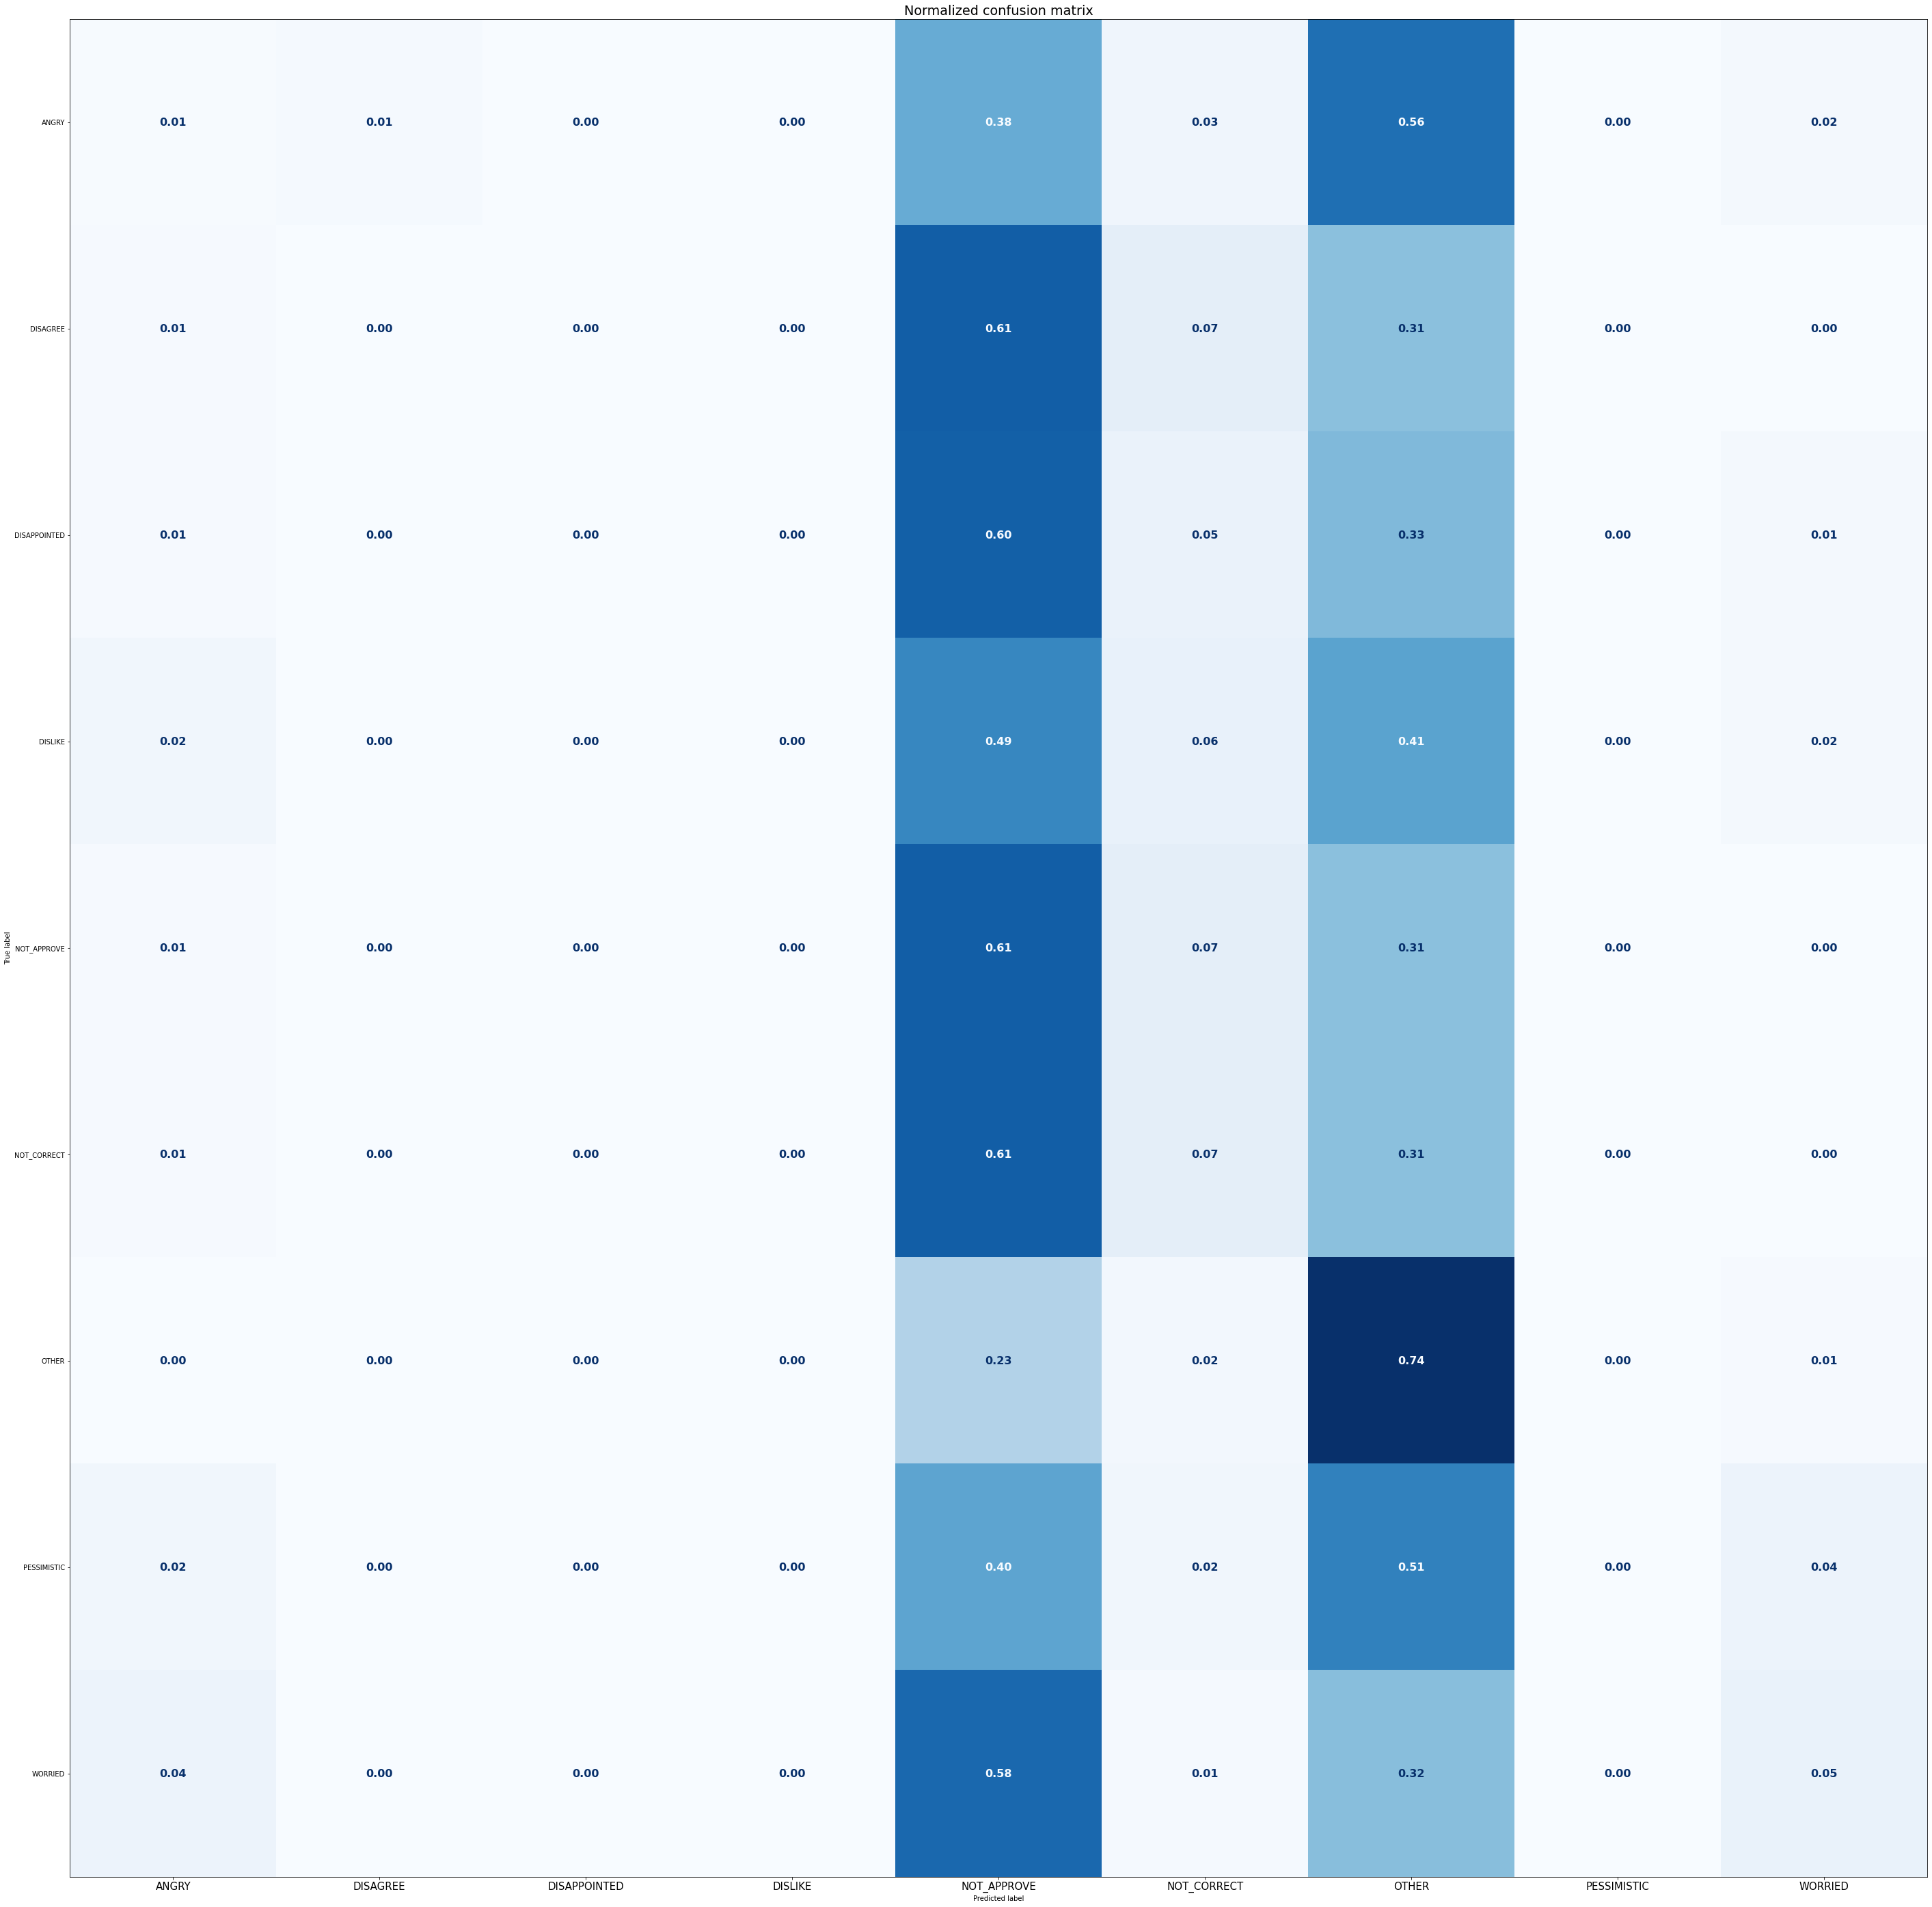

In [14]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(ds_enc["test"]["label"])
plot_confusion_matrix(y_preds, y_valid, labels.names)

In [15]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")     
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

ds_enc.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
ds_enc["test"] = ds_enc["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Parameter 'function'=<function forward_pass_with_label at 0x7f262285db80> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 393/393 [00:09<00:00, 42.64ba/s]


In [16]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

In [17]:
ds_enc.set_format("pandas")
cols = ["text", 'emotions', "label", "predicted_label", "loss"]
df_test = ds_enc["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [18]:
loss_values = df_test.sort_values("loss", ascending=False).head(50)
loss_values

,text,emotions,label,predicted_label,loss
728,no one cares my guy,"[disappointment, sadness]",DISAPPOINTED,OTHER,4.191439
3306,"You spend time in The Donald, do you not under...",[annoyance],DISLIKE,OTHER,4.000267
5824,You sure seem angry. #itwillbeokay,[annoyance],DISLIKE,OTHER,3.985869
4906,"oh, my bad",[disappointment],DISAPPOINTED,OTHER,3.896572
3343,“[NAME] you’re still here? Geez you really are...,[disappointment],DISAPPOINTED,OTHER,3.886158
5598,"You just made my point, you obnoxious whining kid",[disappointment],DISAPPOINTED,OTHER,3.800211
4678,80% of the country is putting their faith in a...,"[annoyance, disappointment, disapproval]",DISAPPOINTED,NOT_APPROVE,3.781373
3500,"Being a nice, interesting person has helped me...",[disappointment],DISAPPOINTED,NOT_APPROVE,3.738756
5868,Oh boy do I have some bad news for you!,[disappointment],DISAPPOINTED,OTHER,3.733219
1184,But but r/49ers said it was just bad luck!,"[disappointment, sadness]",DISAPPOINTED,OTHER,3.707050


In [19]:
loss_values.to_csv('loss_values_functions_basic_goemotions_finetuning_singlelabel.tsv',header =True, sep = '\t',index=False)
df_test.to_csv('preds_functions_basic_goemotions_finetuning_singlelabel.tsv',header =True, sep = '\t',index=False)